# Problem 1

### 1. Load the pre-trained VGG16 convolutional neural network model without the output layer. Check-out the summary of the model. How many layers have been used in the model? How many parameters needed to be optimized?

There are 19 layers used in the model and 14,714,688 parameters that need to be optimized.

In [7]:
from scipy.misc import imsave
from keras import applications
import numpy as np
import time
from keras import backend as K
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [76]:
# build the VGG16 network
model = applications.VGG16(include_top=False,
                           weights='imagenet')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### 2. We will look into the behavior of a specific layer of the network. Select the 1st filter of the 3rd convolutional layer of the 5th block of the network as the filter of interest. You can look through the demo for this part. Feed a gray image with random noise to the filter and perform gradient ascent for 20 times with the learning rate µ = 1.0. Plot the output image

In [77]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

In [78]:
# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

In [79]:
# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [80]:
# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
if K.image_data_format() == 'channels_first':
    input_img_data = np.random.random((1, 3, img_width, img_height))
else:
    input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

# we run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    print loss_value

11.4236
23.3931
39.0296
56.5878
80.8812
104.052
128.079
152.006
175.942
200.093
225.652
246.722
268.026
292.759
313.885
338.328
359.302
383.508
405.981
429.207


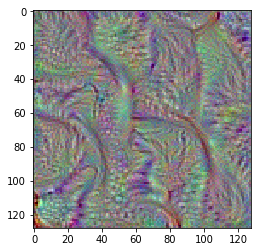

In [81]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
plt.imshow(img)

### 3. We can extend this part for all of the layers. Feed a gray image with random noise to the first convolutional layer of each block. Note that each layer has a different number of filters. Use the range of 64 filters and plot the 12 results that maximize the activation of the corresponding filter. How are the outputs evolving as we go up in the layers? Can you find any patterns? Comment on the results.

block1_conv1


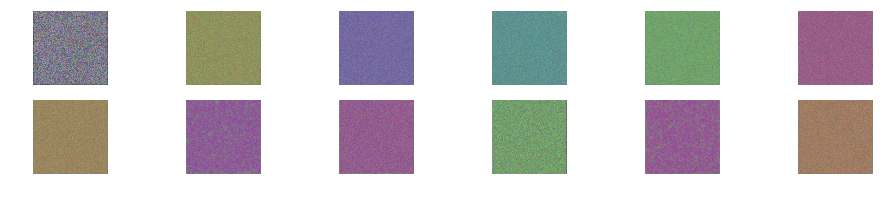

block2_conv1


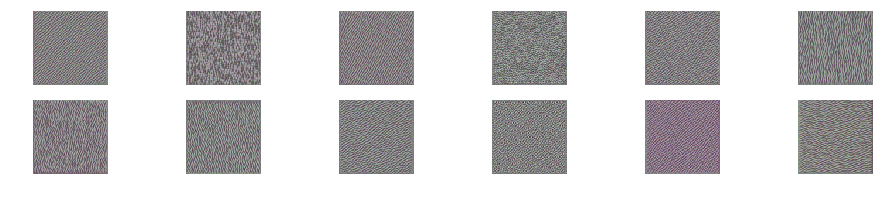

block3_conv1


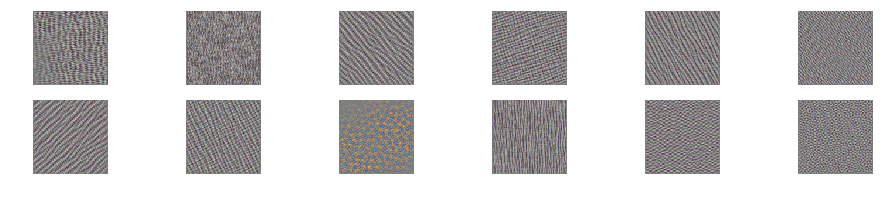

block4_conv1


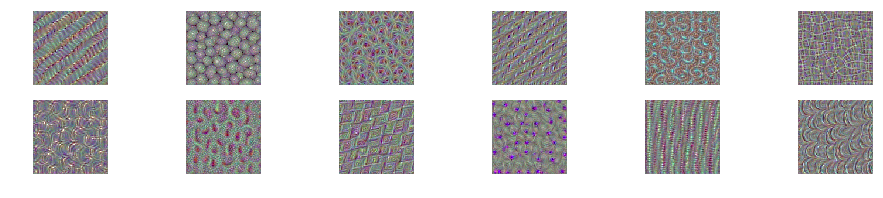

block5_conv1


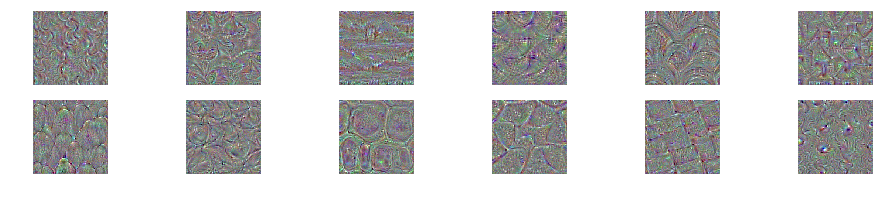

In [11]:
for i in range(5):
    blockname = str(i+1)
    layer_name = 'block'+blockname+'_conv1'
    kept_filters = []
    
    print(layer_name)
    
    for filter_index in range(64):
        # we only scan through the first 64 filters,
        # but there are actually 512 of them
        #print('Processing filter %d' % filter_index)
        start_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.

        # we start from a gray image with some random noise
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 3, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

            #print('Current loss value:', loss_value)
            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break

        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
        end_time = time.time()
        #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 12 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:2 * 6]

    plt.figure(figsize=(16, 3))
    for i in range(12):
        img, loss = kept_filters[i]
        plt.subplot(2,6,i+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

As we go up in layers we see the filters increase in complexity. The first layers capture color and direction of the input. Then as we move up, these filters combine to find grids and textures, which turn into complex patterns. This reflects how the model is trying to capture more information at each layer it passes through. As per the example used in lab, the model may see a simple shape and outline, then as this passes through more layers, it understands that the shape and outline is an head and it can identify the eyes and the nose through more layers.
 
A lot of these filters seem identical, merely rotated by some 90 degrees, which means that we could compress the number of filters by finding a way to make the convolution filters rotation-invariant.

### 4. We do not have to feed a random image. Feed an actual image of your choosing to the filter we used in the first part. Again, use gradient ascent for 20 times and plot the output image.

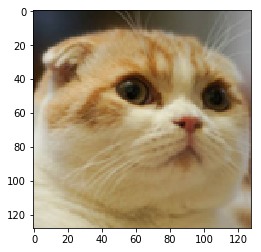

In [17]:
from scipy.misc import imread

img_cat = imread("img_cat.png")
plt.imshow(img_cat)
plt.show()

In [66]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

In [67]:
input_img_cat = img_cat.reshape((1, 128, 128, 3)).astype("float32")

15.491
60.599
113.435
164.115
211.783
255.851
298.79
339.604
380.618
419.973
459.098
496.747
535.634
574.879
616.119
654.853
693.08
729.294
769.234
808.902


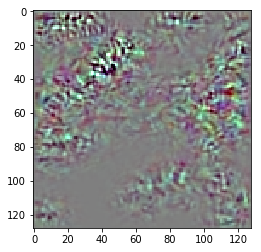

In [68]:
# we run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_cat])
    input_img_cat += grads_value * step
    print loss_value

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
plt.imshow(img)

### 5. Now, we will look into how the network is classifying the images. For this part, we also need the output layer of the network. Load VGG convolutional network with the output layer this time. We first use output index = 65 which corresponds to ’Sea Snake’ class in ImageNet. Feed a gray image with random noise to the filter corresponding to the specified output index. Perform gradient ascent 20 times and report the loss at each step. How sure your network is about the image being a sea snake? Plot the output image. Does it look like a sea snake? Why did network decide that it is a sea snake with the corresponding probability? Comment on the results.

In [27]:
output_index = 65

In [28]:
model = applications.VGG16(include_top=True,
                           weights='imagenet')
loss = K.mean(model.output[:, output_index])

In [30]:
# dimensions of the generated pictures for each filter.
img_width = 224
img_height = 224

# this is the placeholder for the input images
input_img = model.input

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
if K.image_data_format() == 'channels_first':
    input_img_data = np.random.random((1, 3, img_width, img_height))
else:
    input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

0.00166097
0.00302581
0.0062281
0.0142895
0.0231145
0.0957732
0.179778
0.281127
0.279875
0.602333
0.90946
0.931888
0.987567
0.995845
0.997114
0.997583
0.997877
0.998085
0.998247
0.998378


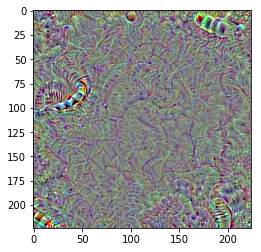

In [33]:
# we run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    print loss_value

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
plt.imshow(img)

At the output layer, our network is 99.84% confident that the gray image we started with is a sea snake. The shape and pattern of the objects near (25, 30), (180, 25), (200, 200), and (0, 200) have some resemblance to a sea snake. But we cannot say that the output image looks anything like a sea snake. This shows how the network doesn't really "understand" what a sea snake is in the way that we humans do. The network decided that the image is a sea snake because at each step, the gradient of the loss function is added. The model goes into thinking that it's looking for a sea snake so the model tries to find it.

### 6. Change the output index we used to output index = 18, which corresponds to ’Magpie’ class in ImageNet. Perform the same tasks as in part 5. Report the losses and plot the output image. How sure your network is about the image belonging to this class? Does the output look like a magpie? Comment on the results.


In [83]:
output_index = 18

In [84]:
model = applications.VGG16(include_top=True,
                           weights='imagenet')
loss = K.mean(model.output[:, output_index])

In [85]:
# dimensions of the generated pictures for each filter.
img_width = 224
img_height = 224

# this is the placeholder for the input images
input_img = model.input

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
if K.image_data_format() == 'channels_first':
    input_img_data = np.random.random((1, 3, img_width, img_height))
else:
    input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

0.00137458
0.000936031
0.00183083
0.00337177
0.00465981
0.00555289
0.0106323
0.020332
0.0235547
0.04103
0.0443629
0.08671
0.170085
0.26371
0.483195
0.798974
0.886799
0.941052
0.985725
0.99244


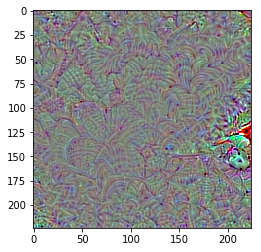

In [91]:
# we run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    print loss_value

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
plt.imshow(img)

At the output layer, our network is 99.24% confident that the gray image we started with is a magpie. The patterns on the image look akin to feathers that a magpie might have, and it seems like the network thinks it identified a head or peak on the right side of the output image, but as a whole, the output image looks nothing like a magpie. Only local textures have some resemblance.

# Problem 2

### 1. Train the model using training data in the CIFAR-10 dataset and cifar10 train.py provided in the tutorial. Note that this script uses the ’random flip’ and ’random distortion’ on training images to augment the training dataset. After the training, evaluate your model using test set provided in CIFAR-10 and cifar10 eval.py provided in the tutorial. Report your results.

Training at max_steps = 10000 yielded a precision of **81.6%** at evaluation.

### 2. Now, remove ’random flip’ pre-processing step. Train and evaluate your model. Report your results. What do you think was the effect of the ’random flip’?

Commenting out

In [ ]:
distorted_image = tf.image.random_flip_left_right(distorted_image)

in cifar10_input.py with training at max_steps = 10000 yielded a precision of **80.5%** at evaluation. This step randomly flipped the image horizontally in part of the image processing for training the network.

### 3. Now, remove ’random distortion’ pre-processing step. Train and evaluate your model. Report your results. What do you think was the effect of the ’random distortion’?


Commenting out

In [ ]:
distorted_image = tf.image.random_brightness(distorted_image,
                                           max_delta=63)
distorted_image = tf.image.random_contrast(distorted_image,
                                         lower=0.2, upper=1.8)

in cifar10_input.py with training at max_steps = 10000 yielded a precision of **81.2%** at evaluation. This step distorted the image by applying random brightness and random constrast to the input in part of the image processing for training the network.

### 4. Comment on your findings. Did using pre-processing steps improve the overall performance? Why or why not pre-processing improved the performance of the model? Provide your insights.

Overall, yes, pre-processing steps improved the performance. Pre-processing images generates distortions of images that are inputed.

This helps inflate the training set allowing more variations of the original image to be recognized.
A larger training set helps improves the training of a model, and thus will increase the overall perfromance in prediction.


### 5. What other pre-processing methods can be applied to the training or test set to improve the performance of the learning models? Propose a possible pre-processing method. You do not have to apply it.

![](http://i.markdownnotes.com/image_1SSju6q.png)

In cifar10_input.py, the preprocessing steps included are:
    * Cropping
    * Flipping
    * Changing Brightness
    * Changing Contrast
    
Other techniques that might work include:

###  Other Pre-processing techniques:

1) **Whitening** (turn the distribution into a normal distribution).

2) **Dimensionality Reduction (e.g. Principal component analysis).** You're basically transforming your data into a compressed space with less dimensions, you control the amount of loss and use that as your input to your network. 

Adding more variation and inflating the training set will likely improve the performance of our models

 # Problem 3) Project Proposal

## Kevin's Project
Team Members:
* Kevin Yee
* Allen Wang
* Aravind Srinivasan
* Ryan O'Farrel

Project Idea: 
Predicting views and ratings for YouTube videos given thumbnails, descriptions, titles

Datasets:
https://research.google.com/youtube8m/
https://www.kaggle.com/c/youtube8m/data

In this dataset, we have access to:

1. Video id
2. Frame-to-frame image and audio (one per second of video)
3. Category of video
4. Labels of subjects the video is about

In addition to this, we can create a scraper that extracts
1. Views
2. Ratings
3. Description
4. Thumbnails
5. Comments
6. Number of subscribers of the uploader

We will use the thumbnails, description, and title to create models that predict the view counts and ratings. Because of the limited computational power and time for the project, we will be focusing on only videos that are in the category of beauty and health. With these created models, there are a lot of things we can do. Here are some of our ideas:

Create a new video on YouTube, predict the views and ratings, and see how well our model does.

We are planning on using a CNN for the thumbnails - we could activate hidden layers and use these to try and answer some questions:

Does having a female in the picture make a difference?

Does text in the pictures make a difference? 
etc.
If we have access tothe comments, we can use an LSTM encoder-decoder with Attention Mechanism to generate comments
Run a sentiment analysis on the comments and see if it reflects the ratings
Try to find out if there are “click-bait” words in titles, thumbnails, descriptions, etc.

## Rachel's Project

Team: Stefan Bordovsky, Rachel Chen, Kyle Grier, Danny Sutanto

Our idea: Generate ambient music through a selected mood e.g. happy, sad, tense, chill

First we need to scrape the web for labeled ambient music. We plan to scrape YouTube to download small clips of music files of videos like “Happy Ambient Music for 10 hours” or “Endless Tense Ambient Background Music” for us to use in our training set.

Then we will teach a neural net how to generate its own ambient music from noise vectors and input mood type, taking inspiration from projects like WaveNet.

Through this project we hope to answer many interesting questions like
* What musical characteristics do certain moods imply? (Key, chord progression, rhythm, etc)
* What is the need/desire behind ambient music?
* Why are people listening to these tracks? Others are uploading their music for a reason.
* Does our generated music have any semblance to what’s on YouTube?

Preliminary Scraping: https://github.com/sbordov/EE379K
